In [1]:
from mobile_sam import SamAutomaticMaskGenerator
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is bec

In [38]:
FILEPATH = "wow.jpeg"

In [21]:
image = cv2.imread(FILEPATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [12]:
image.shape

(1200, 1173, 3)

In [4]:
rowShifted = np.zeros((1192, 800, 3), dtype=np.uint8)
rowOffset = 1
rowShifted[rowOffset:] = image[:-rowOffset]

columnShifted = np.zeros((1192, 800, 3), dtype=np.uint8)
columnOffset = 1
columnShifted[:, 1:] = image[:, :-1]

In [ ]:
rowDifference = image - rowShifted
columnDifference = image - rowShifted
aggregateDifference = (rowDifference + columnDifference)

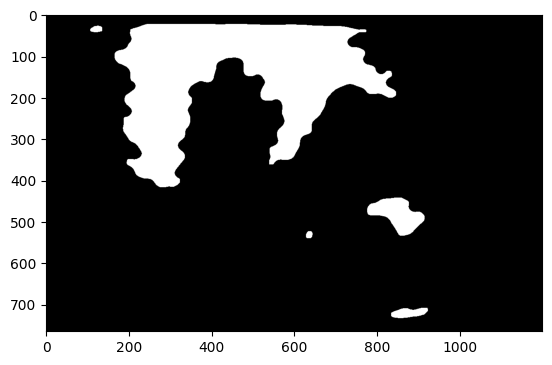

In [39]:
image = cv2.imread(FILEPATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gaussFilter = cv2.GaussianBlur(image, (31, 31), 9)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
closedData = cv2.morphologyEx(gaussFilter, cv2.MORPH_CLOSE, kernel)
_, maxImage = cv2.threshold(closedData, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
maxImage = cv2.dilate(maxImage.astype(np.uint8), kernel=np.ones((5,5), np.uint8))
plt.imshow(maxImage, cmap='gray')

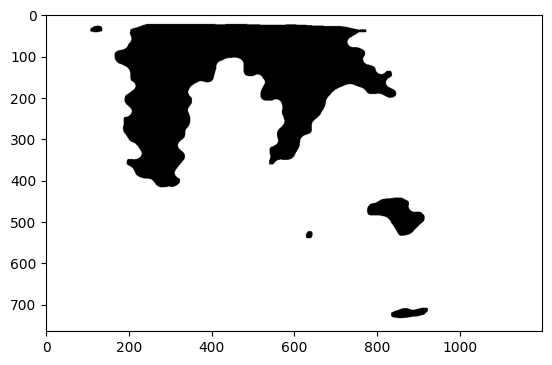

In [48]:
plt.imshow(np.invert(maxImage), cmap='gray', vmin=0, vmax=255)

In [7]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../weights/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

mask_generator = SamAutomaticMaskGenerator(sam)

In [13]:
masks = mask_generator.generate(image)

In [18]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 